# <div style="text-align: center">Building a Machine Learning Sales Prediction Model</div>


In [4]:
import numpy as np

In [5]:
import matplotlib.pyplot as plt

In [6]:
import seaborn as sns

In [7]:
import pandas as pd

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
from sklearn.metrics import mean_squared_error

In [56]:
from sklearn.linear_model import Ridge

In [61]:
from sklearn.linear_model import Lasso

In [66]:
from sklearn.linear_model import ElasticNet

In [69]:
from sklearn.tree import DecisionTreeRegressor

In [79]:
from sklearn.model_selection import KFold

In [112]:
from sklearn.ensemble import RandomForestRegressor

In [173]:
import xgboost as xgb

In [11]:
%matplotlib inline

In [12]:
df=pd.read_csv("./data/Advertising_Budget_and_Sales.csv")

In [13]:
df.head()

,Unnamed: 0,TV Ad Budget ($),Radio Ad Budget ($),Newspaper Ad Budget ($),Sales ($)
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In this dataset, each row represents the amount of money invested in specific advertising channels (TV, radio, and newspaper) and the resulting sales revenue. Our objective is to develop a model capable of predicting estimated sales based on the allocated budget across these advertising channels

## DATA PREPARATION

First, we modify the column names

In [14]:
df.columns=df.columns.str.lower().str.replace(' ','_')

In [15]:
new_column_names = {
    'tv_ad_budget_($)': 'tv_ad_budget',
    'radio_ad_budget_($)': 'radio_ad_budget',
    'newspaper_ad_budget_($)': 'newspaper_ad_budget',
    'sales_($)':'sales'
}

In [16]:
df = df.rename(columns=new_column_names)

In [17]:
df.head()

,unnamed:_0,tv_ad_budget,radio_ad_budget,newspaper_ad_budget,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


Now we delete the unnamed column because it doesn´t provide any useful information

In [18]:
del df['unnamed:_0']

In [19]:
df.head()

,tv_ad_budget,radio_ad_budget,newspaper_ad_budget,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [20]:
df.shape

(200, 4)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   tv_ad_budget         200 non-null    float64
 1   radio_ad_budget      200 non-null    float64
 2   newspaper_ad_budget  200 non-null    float64
 3   sales                200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


we dont see any missing values in the dataset

In [22]:
df.describe()

,tv_ad_budget,radio_ad_budget,newspaper_ad_budget,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


## EDA

Distribution of the sales column(our target):

<Axes: xlabel='sales', ylabel='Count'>

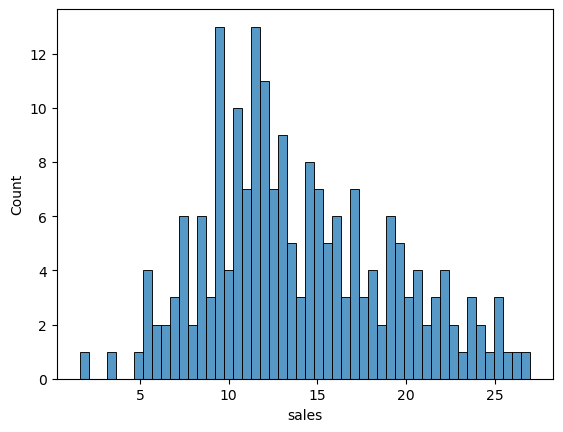

In [23]:
sns.histplot(df.sales, bins=50)

we can see we have something similar to a normal distribution which is ideal

C:\Users\marti\anaconda3\envs\ml-zoomcamp\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


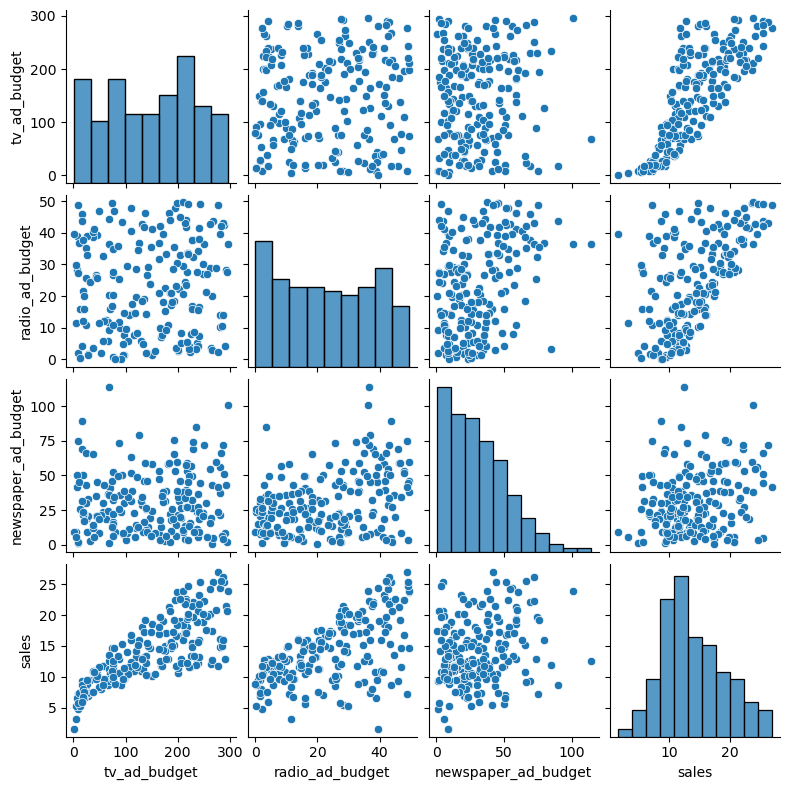

In [24]:
sns.pairplot(df,height=2)

we can see there seems to be a correlation between radio_ad_budget and sales, and between tv_ad_budget and sales

now we analize the linear correlation between variables

<Axes: >

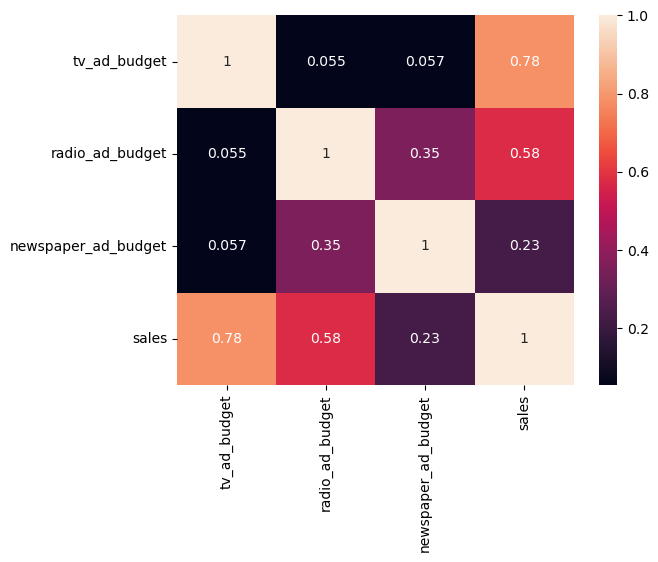

In [25]:
sns.heatmap(df.corr(),annot=True)

we confirm what we saw in the pairplot.

now we will check if there are any outliers:

<Axes: ylabel='tv_ad_budget'>

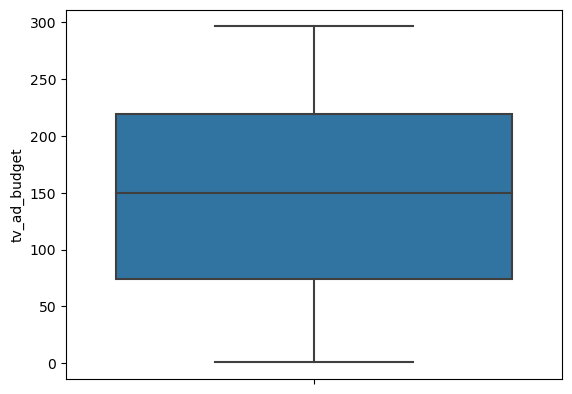

In [26]:
sns.boxplot(y=df.tv_ad_budget)

<Axes: ylabel='radio_ad_budget'>

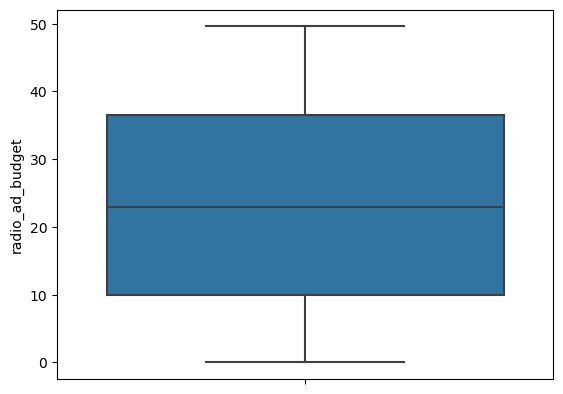

In [27]:
sns.boxplot(y=df.radio_ad_budget)

<Axes: ylabel='newspaper_ad_budget'>

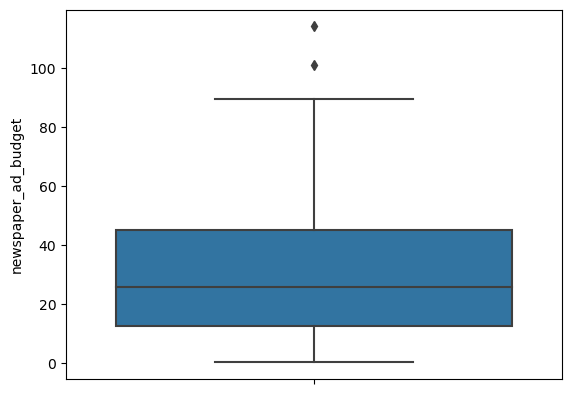

In [28]:
sns.boxplot(y=df.newspaper_ad_budget)

we can clearly see 2 outliers in the newspaper_ad_budget column

In [29]:
outliers=df[df.newspaper_ad_budget>90]
outliers

,tv_ad_budget,radio_ad_budget,newspaper_ad_budget,sales
16,67.8,36.6,114.0,12.5
101,296.4,36.3,100.9,23.8


We delete both outliers

In [30]:
outlier_index=df[df.newspaper_ad_budget>90].index

In [31]:
df.drop(outlier_index,inplace=True)

In [32]:
df.shape

(198, 4)

<Axes: ylabel='newspaper_ad_budget'>

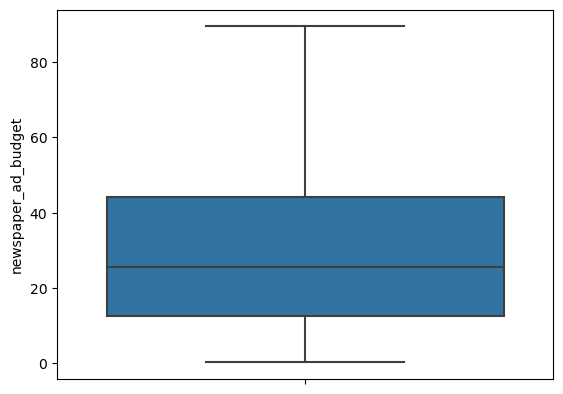

In [33]:
sns.boxplot(y=df.newspaper_ad_budget)

## MODEL TRAINING

we start by splitting the data:

In [34]:
df_full_train, df_test=train_test_split(df, test_size=0.2,random_state=1)

In [35]:
df_train, df_val =train_test_split(df_full_train,test_size=0.25,random_state=1)

In [36]:
df_train=df_train.reset_index(drop=True)
df_val=df_val.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)

In [37]:
y_train=df_train.sales.values
y_val=df_val.sales.values
y_test=df_test.sales.values

In [38]:
del df_train['sales']
del df_val['sales']
del df_test['sales']

In [39]:
X_train=df_train.values
X_val=df_val.values
X_test=df_test.values

# Now we start training different models with different algorithms

### First we train a model with linear regression

In [44]:
def train_linear_regression():
    train_linear_regression= LinearRegression()
    reg=train_linear_regression.fit(X_train,y_train)
    y_pred=reg.predict(X_val)
    rmse=np.sqrt(mean_squared_error(y_val, y_pred))
    df_model=pd.DataFrame({"Real":y_val,"Predict":y_pred})
    
    print(df_model.head())
    print('')
    print(f'RMSE= {rmse}')

In [45]:
train_linear_regression()

   Real    Predict
0  23.7  21.213146
1  21.8  21.249433
2  15.9  19.094692
3  22.6  20.755628
4   4.8   3.721101

RMSE= 2.104624041224318


### Now we train another model with linear regression but now applying np.log1p() transformation to make the target variable more normally distributed although the distribution is already similar to a normal distribution. lets see if we can get an improvement in performance:

In [54]:
def train_linear_regression_normalized():
    y_train_2=np.log1p(y_train)
    y_val_2=np.log1p(y_val)
    y_test_2=np.log1p(y_test)
    
    train_linear_regression= LinearRegression()
    reg=train_linear_regression.fit(X_train,y_train_2)
    y_pred=reg.predict(X_val)
    rmse=np.sqrt(mean_squared_error(np.expm1(y_val_2), np.expm1(y_pred)))
    df_model=pd.DataFrame({"Real":np.expm1(y_val_2),"Predict":np.expm1(y_pred)})
    
    print(df_model.head())
    print('')
    print(f'RMSE= {rmse}')
    

In [55]:
train_linear_regression_normalized()

   Real    Predict
0  23.7  21.754474
1  21.8  22.351672
2  15.9  19.777873
3  22.6  21.322262
4   4.8   5.991867

RMSE= 1.9667313212465198


### Now we apply different types of regularization:

#### Ridge regularization

In [59]:
def ridge_regularization():
    for r in [0,0.0001,0.001,0.01,0.1,1,10,100]:
        clf = Ridge(solver='sag',alpha=r)
        clf.fit(X_train, y_train)
        y_pred=clf.predict(X_val)
        
        rmse=np.sqrt(mean_squared_error(y_val, y_pred))
        print(f'r={r} => rmse={rmse}')
    
    
    

In [60]:
ridge_regularization()

r=0 => rmse=2.104466731822051
r=0.0001 => rmse=2.1046911084429625
r=0.001 => rmse=2.104708037917389
r=0.01 => rmse=2.1047148925580026
r=0.1 => rmse=2.1046862679487557
r=1 => rmse=2.104545279739998
r=10 => rmse=2.1048035221266255
r=100 => rmse=2.1068163976441454


#### Lasso regularization

In [64]:
def lasso_regularization():
    for r in [0.0001,0.001,0.01,0.1,1,2,5,10,100]:
        clf = Lasso(alpha=r)
        clf.fit(X_train, y_train)
        y_pred=clf.predict(X_val)
        rmse=np.sqrt(mean_squared_error(y_val, y_pred))
        print(f'r={r} => rmse={rmse}')

In [65]:
lasso_regularization()

r=0.0001 => rmse=2.104625901379641
r=0.001 => rmse=2.104642734286968
r=0.01 => rmse=2.10480505302525
r=0.1 => rmse=2.106417335199607
r=1 => rmse=2.1171433676534126
r=2 => rmse=2.131223867996495
r=5 => rmse=2.18666227289265
r=10 => rmse=2.319522393375736
r=100 => rmse=3.8296133367812213


#### Elasticnet regularization

In [102]:
def elasticnet_regularization():
    for r in [0.0001,0.001,0.01,0.1,1,2,5,10,100]:
        clf = ElasticNet(alpha=r)
        clf.fit(X_train, y_train)
        y_pred=clf.predict(X_val)
        rmse=np.sqrt(mean_squared_error(y_val, y_pred))
        print(f'r={r} => rmse={rmse}')

In [103]:
elasticnet_regularization()

r=0.0001 => rmse=2.1046250864263203
r=0.001 => rmse=2.104634584393921
r=0.01 => rmse=2.1047300164829243
r=0.1 => rmse=2.105701605433371
r=1 => rmse=2.1120587808041993
r=2 => rmse=2.1195272946992114
r=5 => rmse=2.146255228527539
r=10 => rmse=2.204059063442535
r=100 => rmse=3.72794094219273


### Another model trained with an algorithm called desicion tree:

In [110]:
def train_decisiontree_1():
    dt=DecisionTreeRegressor(random_state=42)
    dt.fit(X_train,y_train)
    y_pred = dt.predict(X_val)
    rmse_val=np.sqrt(mean_squared_error(y_val, y_pred))
    y_pred_2 = dt.predict(X_train)
    rmse_train=np.sqrt(mean_squared_error(y_train, y_pred_2))
    print(f'RMSE for validation dataset: {rmse_val}')
    print(f'RMSE for training dataset: {rmse_train}')
    
    
    

In [111]:
train_decisiontree_1()

RMSE for validation dataset: 1.057000473036791
RMSE for training dataset: 0.0


this means it is overfitting, so we will have to tune hyperparameters. and at the same time we will apply cross validation  to get a more stable estimate of the model performance.

In [143]:
def dt_parameter_tuning():
    print('Searching for the best depth value:')
    print('')
    for depth in [1, 2, 3, 4, 5, 6,7,8, 10, 15, 20,30, 50, None]:
        kfold = KFold(n_splits=15, shuffle=True, random_state=42)

        scores = []

        for train_idx, val_idx in kfold.split(df_full_train):
            df_train_dt = df_full_train.iloc[train_idx]
            df_val_dt = df_full_train.iloc[val_idx]

            y_train_dt = df_train_dt.sales.values
            y_val_dt = df_val_dt.sales.values
        
            del df_train_dt["sales"]
            del df_val_dt["sales"]

            X_train_dt=df_train_dt.values
            X_val_dt=df_val_dt.values

            model = DecisionTreeRegressor(max_depth=depth,random_state=42)
            model.fit(X_train_dt, y_train_dt)
            y_pred= model.predict(X_val_dt)

            rmse = np.sqrt(mean_squared_error(y_val_dt, y_pred))
            scores.append(rmse)

        print('depth=%s %.3f +- %.3f' % (depth,np.mean(scores), np.std(scores)))
    print("So the depth that leads to the lowest rmse is depth=10")
    print('')
    print('Now, we set the value for max_depth to 10 and tune min_samples_leaf:')
    print('')
    
    #searching for the best min_samples_leaf value:
    
    for s in [1, 2,3,4,5, 10, 15, 20, 500, 100, 200]:
        kfold = KFold(n_splits=15, shuffle=True, random_state=42)

        scores = []

        for train_idx, val_idx in kfold.split(df_full_train):
            df_train_dt = df_full_train.iloc[train_idx]
            df_val_dt = df_full_train.iloc[val_idx]

            y_train_dt = df_train_dt.sales.values
            y_val_dt = df_val_dt.sales.values
        
            del df_train_dt["sales"]
            del df_val_dt["sales"]

            X_train_dt=df_train_dt.values
            X_val_dt=df_val_dt.values

            model = DecisionTreeRegressor(max_depth=10,min_samples_leaf=s,random_state=42)
            model.fit(X_train_dt, y_train_dt)
            y_pred= model.predict(X_val_dt)

            rmse = np.sqrt(mean_squared_error(y_val_dt, y_pred))
            scores.append(rmse)

        print('min_samples_leaf=%s %.3f +- %.3f' % (s,np.mean(scores), np.std(scores)))
    print('Best value is min_samples_leaf=2')
    
    
    

In [144]:
dt_parameter_tuning()

Searching for the best depth value:

depth=1 3.716 +- 1.054
depth=2 2.441 +- 0.546
depth=3 2.209 +- 0.554
depth=4 1.670 +- 0.453
depth=5 1.351 +- 0.420
depth=6 1.227 +- 0.362
depth=7 1.239 +- 0.316
depth=8 1.235 +- 0.358
depth=10 1.211 +- 0.354
depth=15 1.229 +- 0.324
depth=20 1.229 +- 0.324
depth=30 1.229 +- 0.324
depth=50 1.229 +- 0.324
depth=None 1.229 +- 0.324
So the depth that leads to the lowest rmse is depth=10

Now, we set the value for max_depth to 10 and tune min_samples_leaf:

min_samples_leaf=1 1.211 +- 0.354
min_samples_leaf=2 1.130 +- 0.345
min_samples_leaf=3 1.198 +- 0.355
min_samples_leaf=4 1.286 +- 0.371
min_samples_leaf=5 1.386 +- 0.366
min_samples_leaf=10 1.759 +- 0.483
min_samples_leaf=15 2.087 +- 0.531
min_samples_leaf=20 2.199 +- 0.380
min_samples_leaf=500 5.126 +- 0.974
min_samples_leaf=100 5.126 +- 0.974
min_samples_leaf=200 5.126 +- 0.974
Best value is min_samples_leaf=2


In [147]:
def decision_tree_final():
    dt= DecisionTreeRegressor(max_depth=10, min_samples_leaf=2,random_state=1)
    dt.fit(X_train, y_train)
    y_pred= dt.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print(f'RMSE= {rmse}')
    y_pred_train = dt.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    print(f"RMSE_train= {rmse_train} (to see if its overfitting.it doesn't)")
    df=pd.DataFrame({"Real":y_val,"Predict":y_pred})
    print('')
    print(df.head())
    
    

In [149]:
decision_tree_final()

RMSE= 1.1943501254750308
RMSE_train= 0.4158579722782102 (to see if its overfitting.it doesn't)

   Real    Predict
0  23.7  23.100000
1  21.8  22.150000
2  15.9  13.333333
3  22.6  22.000000
4   4.8   4.733333


### Now we will train a model with random forest:

In [156]:
def searching_best_number_of_trees():
    scores = []

    for n in range(10, 351, 10):
        rf= RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred= rf.predict(X_val)
        rmse= np.sqrt(mean_squared_error(y_val, y_pred))
    
        scores.append((n, rmse))
    
    df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
    print(plt.plot(df_scores.n_estimators, df_scores.rmse))
    print("")
    print("Lowest rmse is obtained with 180 estimators:")
    print(df_scores[df_scores.rmse==df_scores.rmse.min()])
    


Lowest rmse is obtained with 180 estimators
    n_estimators      rmse
17           180  0.956046


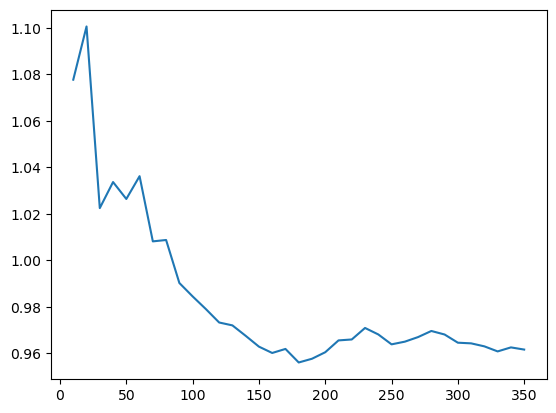

In [157]:
searching_best_number_of_trees()

In [159]:
def best_max_depth_value():
    scores = []

    for d in [5, 10, 15]:
        for n in range(10, 351, 10):
            rf = RandomForestRegressor(n_estimators=n,
                                        max_depth=d,
                                        random_state=1)
            rf.fit(X_train, y_train)

            y_pred= rf.predict(X_val)
            rmse= np.sqrt(mean_squared_error(y_val, y_pred))

            scores.append((d, n, rmse))
            
    columns_rf = ['max_depth', 'n_estimators', 'rmse']
    df_scores = pd.DataFrame(scores, columns=columns_rf)
    
    for d in [5, 10, 15]:
        df_subset = df_scores[df_scores.max_depth == d]
        
        plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

    print(plt.legend())

Legend


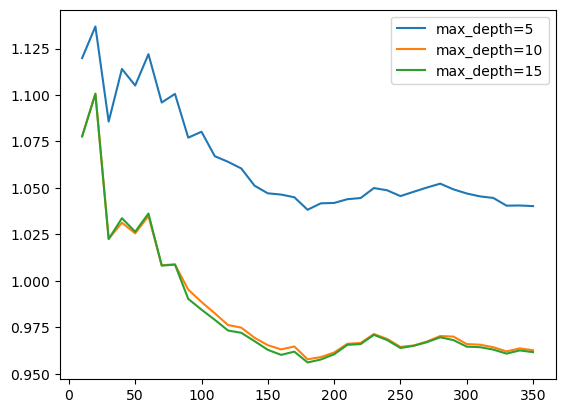

In [160]:
best_max_depth_value()

so max_depth=10 and n_estimators=180

In [162]:
def +--:
    scores = []

    for s in [1,2, 3, 5, 10, 50]:
        for n in range(10, 351, 10):
            rf= RandomForestRegressor(n_estimators=n,
                                    max_depth=10,
                                    min_samples_leaf=s,
                                    random_state=1)
            rf.fit(X_train, y_train)

            y_pred = rf.predict(X_val)
            rmse= np.sqrt(mean_squared_error(y_val, y_pred))

            scores.append((s, n, rmse))
            
    columns = ['min_samples_leaf', 'n_estimators', 'rmse']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    colors = ['black', 'blue', 'orange', 'red', 'grey','yellow']
    values = [1,2, 3, 5, 10, 50]

    for s, col in zip(values, colors):
        df_subset = df_scores[df_scores.min_samples_leaf == s]
    
        plt.plot(df_subset.n_estimators, df_subset.rmse,
             color=col,
             label='min_samples_leaf=%d' % s)

    print(plt.legend())
    

Legend


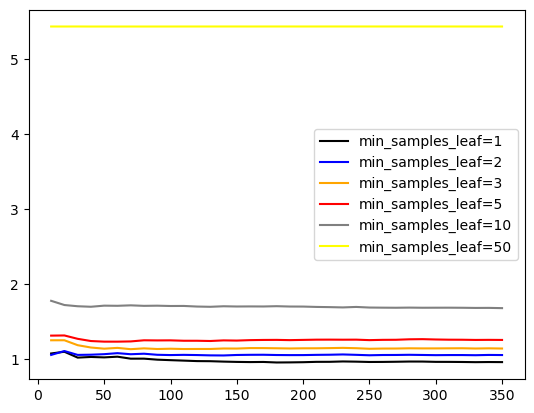

In [163]:
searching_best_min_samples_leaf_value()

So, the values selected are n_estimators=180, max_depth=10 and  min_samples_leaf=1. And with those values I train a RandomForestRegressor:

In [171]:
def train_RandomForestRegressor():
    rf = RandomForestRegressor(n_estimators=180,
                            max_depth=10,
                            min_samples_leaf=1,
                            random_state=1)
    rf.fit(X_train, y_train)
    
    y_pred= rf.predict(X_val)
    rmse= np.sqrt(mean_squared_error(y_val, y_pred))
    print(f"RMSE= {rmse}")
    df5=pd.DataFrame({"Real":y_val,"Predict":y_pred})
    print("")
    print(df5.head())
    
    y_pred_rf_2= rf.predict(X_train)
    rmse_train= np.sqrt(mean_squared_error(y_train, y_pred_rf_2))
    print("")
    print(f"RMSE_FOR_TRAIN_SET= {rmse_train} (to check that its not overfitting)")
    

In [172]:
train_RandomForestRegressor()

RMSE= 0.9577428580532225

   Real    Predict
0  23.7  22.637778
1  21.8  21.170926
2  15.9  14.358889
3  22.6  21.778333
4   4.8   5.166667

RMSE_FOR_TRAIN_SET= 0.2786512461088104 (to check that its not overfitting)


## Now we try xgboost:

In [194]:
# searching_best_number_of_iterations:

features = df_train.columns
    
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
    
watchlist = [(dtrain, 'train'), (dval, 'val')]
    
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    
    'nthread': 8, 
    'seed': 1,
    'verbosity': 1,
}
    
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-rmse:10.21559	val-rmse:10.37960
[5]	train-rmse:2.12765	val-rmse:2.24039
[10]	train-rmse:0.55283	val-rmse:1.04928
[15]	train-rmse:0.20640	val-rmse:0.95525
[20]	train-rmse:0.11463	val-rmse:0.92712
[25]	train-rmse:0.07573	val-rmse:0.92876
[30]	train-rmse:0.05237	val-rmse:0.92810
[35]	train-rmse:0.03534	val-rmse:0.92634
[40]	train-rmse:0.02391	val-rmse:0.92770
[45]	train-rmse:0.01514	val-rmse:0.92711
[50]	train-rmse:0.00999	val-rmse:0.92717
[55]	train-rmse:0.00745	val-rmse:0.92696
[60]	train-rmse:0.00491	val-rmse:0.92680
[65]	train-rmse:0.00359	val-rmse:0.92683
[70]	train-rmse:0.00271	val-rmse:0.92680
[75]	train-rmse:0.00191	val-rmse:0.92667
[80]	train-rmse:0.00152	val-rmse:0.92670
[85]	train-rmse:0.00119	val-rmse:0.92675
[90]	train-rmse:0.00119	val-rmse:0.92675
[95]	train-rmse:0.00119	val-rmse:0.92675
[99]	train-rmse:0.00119	val-rmse:0.92675


num_boost_round=20 seems to be a good number of iterations. after that value the rmse doesn't deacrease significantly

tunning the eta parameter:

In [195]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [196]:
scores = {}

In [ ]:
#I run the following 3 cells with different values for the key 'eta': 0.01,0.05,0.01,0.3,1.0

In [215]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [216]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=1'

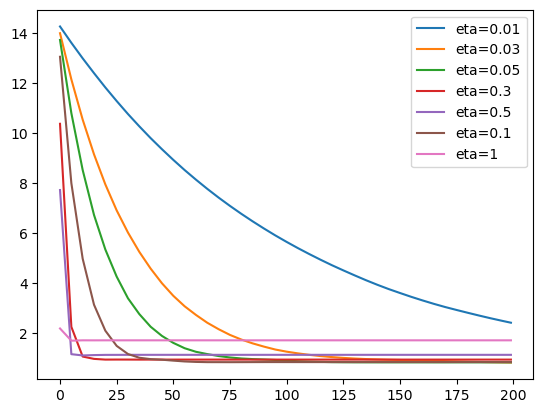

In [217]:
for key,df_score in scores.items():
    plt.plot(df_score.num_iter,df_score.val_rmse,label=key)
plt.legend()

with a value of eta=0.3 it reaches faster a small value of rmse(it learns faster)

now we tune another hyperparameter: max_depth

In [219]:
scores={}

same as before, we run the following 3 cells with different values fot the key 'max_depth'. we try 3,4,6,7,8,12

In [235]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 7,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [236]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=7'

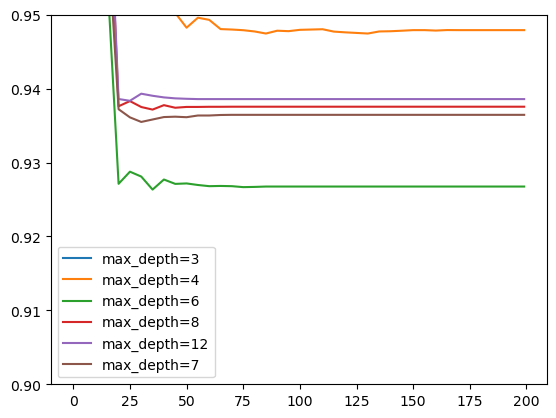

In [237]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=max_depth)

plt.ylim(0.90, 0.95)
plt.legend()

max_depth=6 seems to perform better

now we tune min_child_weight

In [238]:
scores = {}

same as before, we run the following 3 cells with different values fot the key 'min_child_weight'. we try 1,5,10,20,30

In [251]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 7,
    'min_child_weight': 30,
    
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [252]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

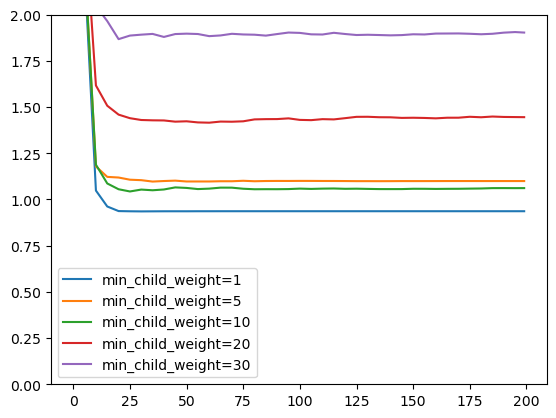

In [253]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=min_child_weight)

plt.ylim(0,2)
plt.legend()

we tain the an xgboost model with the parameters I selected:

In [254]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [256]:
%%capture output
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [257]:
s=output.stdout

In [258]:
df_score=parse_xgb_output(output)

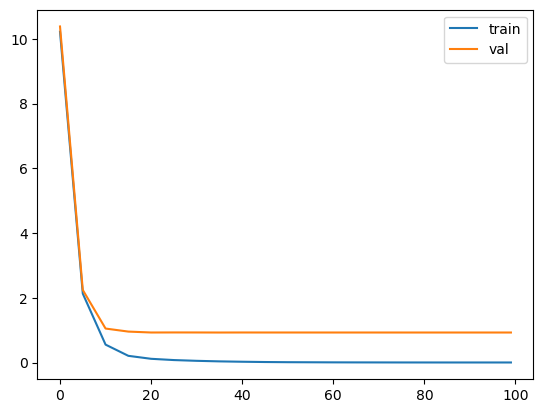

In [259]:
plt.plot(df_score.num_iter, df_score.train_rmse, label='train')
plt.plot(df_score.num_iter, df_score.val_rmse, label='val')
plt.legend()

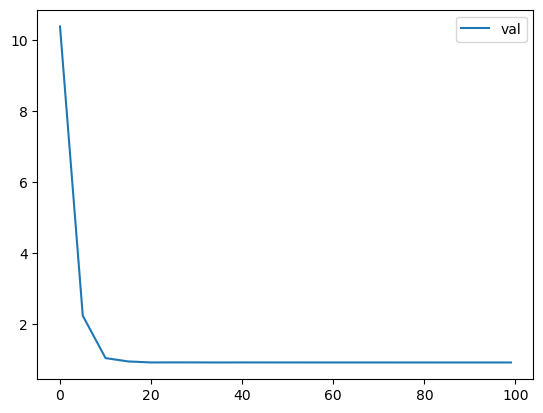

In [262]:
plt.plot(df_score.num_iter, df_score.val_rmse, label='val')
plt.legend()

In [263]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 7,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=20)

In [264]:
y_pred_xgb_f = model.predict(dval)

In [265]:
rmse_xgb_f= np.sqrt(mean_squared_error(y_val, y_pred_xgb_f))

In [266]:
rmse_xgb_f

0.9390247352359993

# Results:

table with the rmse for each model trained with a different algorithm:

| algorithm used to train the model                         | rmse for validation set |
|-----------------------------------------------------------|-------------------------|
|linear regression                                          |        2.1              |
|linear regression with normalization applied to the target |        1.97             |
|L.R with ridge regularization                              |        2.10             |
|L.R with lasso regularization                              |        2.10             |
|L.R with elasticnet regularization                         |        2.10             |
|DecisionTreeRegressor with parameter tunning               |        1.20             |
|randomforests with parameter tuning                        |        0.96             |
|xgboost with parameter tuning                              |        0.94             |


### Xgboost gave us the best performance so we test it with the test dataset and see if the rmse is similar to the one we obtained with the validation dataset:

In [267]:
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

In [268]:
y_pred_xgb_f = model.predict(dtest)

In [269]:
rmse_xgb_f= np.sqrt(mean_squared_error(y_test, y_pred_xgb_f))

In [270]:
rmse_xgb_f

0.9156868009741033

In [271]:
pd.DataFrame({"Real":y_test,"Predict":y_pred_xgb_f})

,Real,Predict
0,11.7,12.751901
1,17.1,17.587456
2,12.8,14.780978
3,7.3,7.205737
4,25.4,24.446934
5,17.6,15.805102
6,11.7,11.332159
7,12.9,13.401721
8,21.4,20.765699
9,15.0,15.432752


### the rmse obtained was as good as the one obtained with the validation dataset, so we will use this model for production